In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pystan
import python.data_import as di
from python.visualize import ExponentialMovingAverage, plot_two_step_data
import pickle
import time
%matplotlib inline

In [2]:
pystan.__version__

'2.19.1.1'

# Model-free and Model-based reinforcement learning

Imagine that you are playing chess. How would you decide your next movement? You can think about how the opponent move by each of your possible movements in advance and decide the action taken with deliberation. Or if you already encounter similar situations before, you would rely on those experiences and take the action reactively. In the former case, we use an internal model of action and its consequences (i.e. our possible movements and opponents reaction) and plan ahead what to do next. This is called model-based reinforcement learning (or planning, deliberation, or goal-directed behavior). In the other case, you use history of past experiences about which actions had led to rewards. This is called model-free reinforcement learning. Biological agents also use such different types of reinforcement learning strategies to make decisions. 

# Two-step decision making task

One well-established task to examine model-based reinforcemeat learning is two-step decision making task. This was originally developed in human (Daw et al.) and also applied in rodent studies (Rats in Miller et al., and mice in Akam et al.,). This task allows us to dissociate model-free from model-based RL modules. In the original task, human subjects were asked to choose among two options at first. After the first choice, state transit probabilisitically to one of two states and again the subject was asked to choose among two options. This second choice gave reward to the subject probabilistically. When first choice was simulated using model-free and model-based RL agents, their choice patterns was distinctive depending on condition of a preceding trial(i.e. whether common or rare transition happens and whether reward was given or not). Model-free RL agent is likely to repeat the same first-step choice when rewarded in a previous trial regardless of type of state transition. On the other hand, model-based RL agent behave as taking into account the state transition. For rodent study, reduced two-step task was used, where there was no choice at the second stage and reward probabilities had block strucuture. 

## Example data: Reduced two-step task in mice (designed based on Akam et al., 2020)
Five holes are located at four directions. At the initial state, mice could poke its nose to a centor port, which led to choice state. In the choice state, mice could choose either left or right port. Their first-step choices probabilistically lit up either upper or lower port. By poking to the illuminating port, water reward was probabilistically given. As same as the original task, simulation using the same task design showed distinctive choice pattern between model-free and model-based RL agents.

![MiceTwoStep.png](imgs/MiceTwoStep.png)




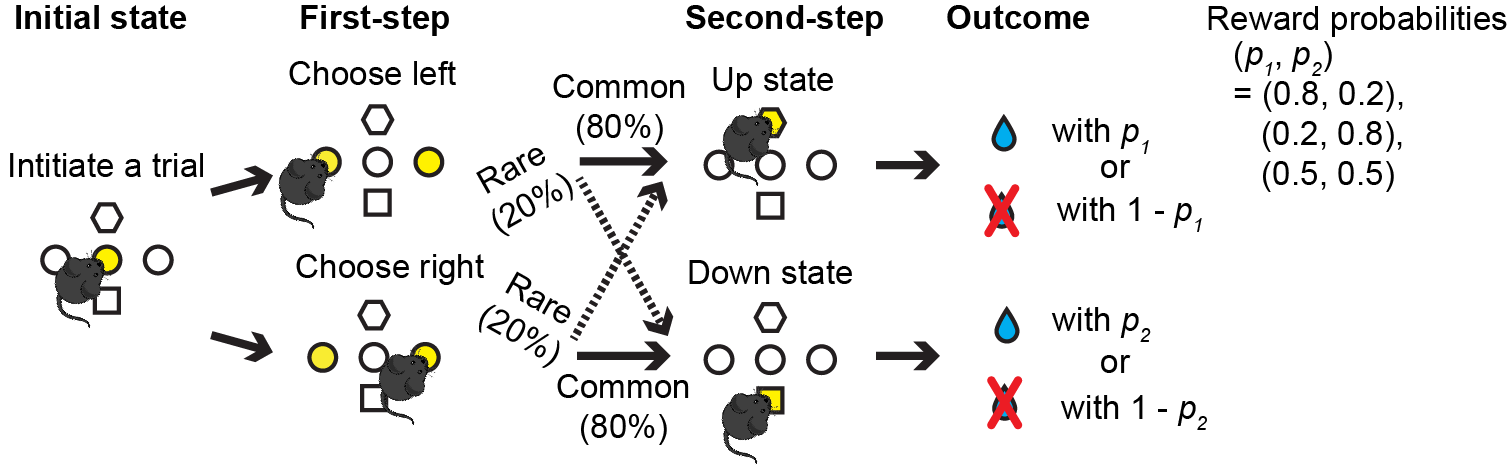

# Visualization of choice behaviors in a session

Importing data file: twostep_data.txt


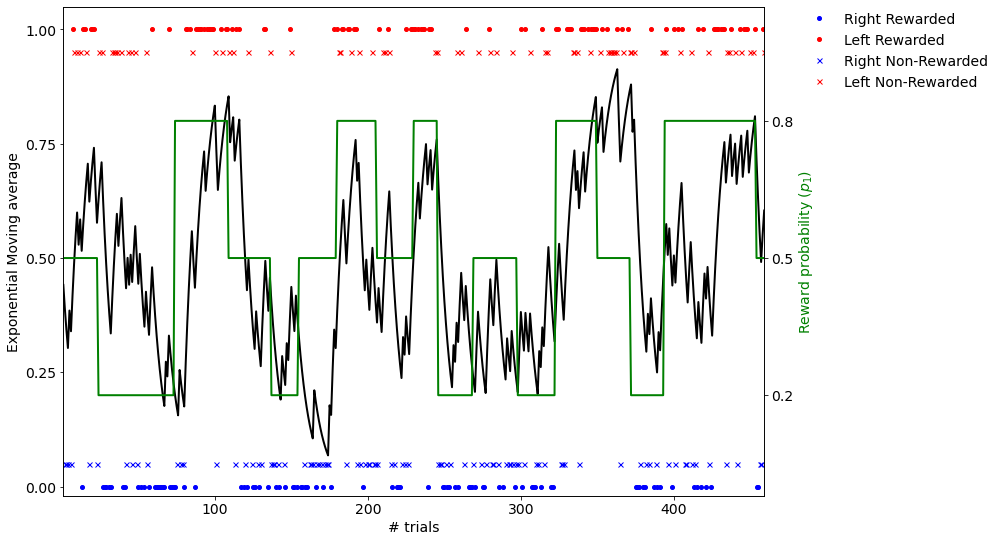

In [4]:
session = di.Session('./data/twostep_data.txt') # import data using data_import.py file
plot_two_step_data(session);

# Model-free/model-based hybrid RL model

In this model, value of choices are calculated based on model-free and model-based RL strategies.

## Model-free RL strategy (value learning from experience)
After observing an outcome at each trial, value of first-step choice taken ($Q_{mf}(c)$) and one not taken ($Q_{mf}(c')$) is updated as

$$Q_{mf}(c) = (1- \alpha) Q_{mf}(c) + \alpha(\lambda r + (1 - \lambda) V(s))$$

$$Q_{mf}(c') = (1- f) Q_{mf}(c')$$

Similarly, the value of second-step state reached ($V(s)$) and not reached ($V(s')$) at the trial is updated as

$$V(s) = (1- \alpha) V(s) + \alpha r$$

$$V(s') = (1- f) V(s)$$

## Model-based RL strategy (value estimate from planning)
Assuming that agents (mice in this example) already know true state transition probability, values of each action was calculated using the knowledge of state transition and second-step state values as follows:

$$Q_{mb}(a) = \sum P(s|a) V(s)$$


## Action selection
Net action values are calculated as weighted sum of two RL strategies. 

$$Q_{net}(a) = \beta_{mf} Q_{mf}(a) + \beta_{mb} Q_{mb}(a)$$

Based on the net action values, action is selected based on softmax decision rule.

$$Q_{net}(a = L) = \frac{1}{1+ \exp(-(Q_{net}(a = L) - Q_{net}(a = R)))}$$


In [42]:
stan_model = """
data {
      int T; // vector of number of trials at each session
      real PR[2];
      real PL[2];
      int<lower=0,upper=2> c[T]; // first stage choice
      int<lower=0,upper=2> ss[T]; // reached second state
      int<lower=0, upper=2> tt[T]; // whether it is forced- or free choice trial
      real r[T]; // reward
    }
    
parameters {
   real<lower=0, upper=1> alpha;
   real<lower=0, upper=1> forget;
   real<lower=0, upper=1> lambda;
   real<lower =0> Wmf;
   real<lower =0> Wmb;
}
model {

  matrix[2,T] Qmb; // Q values (option x trial)
  matrix[2,T] Qmf; // Q values (option x trial)
  matrix[2,T] Qnet; // Q values (option x trial)  
  matrix[2,T] V; // state values of second step states

  // prior of free parameters
  //alpha ~ beta(2,2);
  //forget ~ beta(2,2);
  //lambda ~ beta(2,2);
  //Wmf ~ gamma(2,0.333);
  //Wmb ~ gamma(2,0.333);


  // initial value set
  Qmb[1,1] = 0; // action value for left
  Qmb[2,1] = 0; // action value for right
  Qmf[1,1] = 0; // action value for left
  Qmf[2,1] = 0; // action value for right

  Qnet[1,1] = 0; // action value for left
  Qnet[2,1] = 0; // action value for right

  V[1,1] = 0; // state value for up state
  V[2,1] = 0; // state value for down state

  for ( t in 1:T ) {
      Qmb[1,t] = PL[1] * V[1,t] + PL[2] * V[2,t];  // estimate action value for left choice
      Qmb[2,t] = PR[1] * V[1,t] + PR[2] * V[2,t]; // estimate action value for right choice 

      Qnet[1,t] = Wmb*Qmb[1,t] + Wmf*Qmf[1,t];  // estimate action value for left choice
      Qnet[2,t] = Wmb*Qmb[2,t] + Wmf*Qmf[2,t]; // estimate action value for right choice

      // update likelihood function if trial type is free choice trial
      if (tt[t] == 1){
        target += log(1.0/(1.0 + exp(-(Qnet[c[t],t] - Qnet[3-c[t],t]))));
      }
      
      // update state value
      if (t < T ){
        // value of chosen action
        Qmf[c[t], t+1] = (1 - alpha) * Qmf[c[t], t] + alpha * (lambda * r[t] - (1 - lambda) * V[ss[t], t]);
        // unchosen action
        Qmf[3-c[t], t+1] = (1 - forget) * Qmf[3-c[t], t];       
      
        // value of reached second state
        V[ss[t], t+1] = (1 - alpha) * V[ss[t], t] + alpha* r[t];        
        // unreached second state
        V[3-ss[t],t+1] = (1 - forget) * V[3-ss[t], t];        
      }
  }
}
"""

In [43]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9f121d6419f7f586fcd63fee1d025b51 NOW.


# Arrange behavioral data into format suitable for pyStan

In [71]:
def RL_data_arrange(session):
   
    b = session.print_lines
    T = len(b)
    trial = b[0].split(" ")
    trans_state = int(trial[8][3] == 'A') # 0 = B, 1 = A

    PL = np.zeros(2)
    PR = np.zeros(2)
    
    if trans_state:
        PL[0] = 0.8
        PL[1] = 0.2
        PR[0] = 0.2
        PR[1] = 0.8

    else: 
        PL[0] = 0.2
        PL[1] = 0.8
        PR[0] = 0.8
        PR[1] = 0.2

    c     = np.ones(T, dtype = int) 
    ss = np.ones(T, dtype = int) 
    r = np.zeros(T)
    tt = np.ones(T, dtype = int)

    for j in range(T):
        d = b[j].split(" ")
        if d[4] == 'C:0': # put 2 if choice is right (0)
            c[j] = 2
        if d[5] == 'S:0': # put 2 if second state is down (0) 
            ss[j] = 2
        if d[6] == 'O:1': # 0 = unrewarded, 1 = rewarded
            r[j] = 1
        else:
            r[j] = 0
        if d[9] != 'CT:FC': # put 2 if trial type is forced choice trials (CT:L or R)
            tt[j] = 2
    
    return T, c, ss, tt, r, PR, PL

T, c, ss, tt, r, PR, PL = RL_data_arrange(session)

In [72]:
stan_data = {"T":T,
             "PL":PL,
             "PR":PR,
             "c":c.astype(int),
             "ss":ss.astype(int),
             "tt":tt.astype(int),
             "r": r}

In [ ]:
time_sta = time.perf_counter()
fit = sm.sampling(data = stan_data, iter = 5000, warmup = 750, chains = 4, seed = 123)
time_end = time.perf_counter()

tim = time_end - time_sta

print(tim)

In [40]:
print(sm)

Inference for Stan model: anon_model_892f6fe82f9a2a68120e07430bb6eb2e.
4 chains, each with iter=5000; warmup=750; thin=1; 
post-warmup draws per chain=4250, total post-warmup draws=17000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    0.26  9.5e-4   0.09   0.11   0.19   0.25   0.32   0.47   9483    1.0
forget   0.76  9.6e-4   0.11   0.54    0.7   0.77   0.84   0.95  12156    1.0
lambda   0.58  1.8e-3   0.18   0.22   0.45   0.58   0.72   0.91  10121    1.0
Wmf      2.37    0.02   1.67   0.34   1.22   1.98   3.06   6.76   8963    1.0
Wmb      6.71    0.02   2.03   3.72   5.32   6.38   7.72  11.71   8937    1.0
lp__   -139.6    0.02   1.73 -143.9 -140.5 -139.3 -138.3 -137.3   5773    1.0

Samples were drawn using NUTS at Mon May 30 11:49:00 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'forget'}>,
        <AxesSubplot:title={'center':'forget'}>],
       [<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>],
       [<AxesSubplot:title={'center':'Wmf'}>,
        <AxesSubplot:title={'center':'Wmf'}>],
       [<AxesSubplot:title={'center':'Wmb'}>,
        <AxesSubplot:title={'center':'Wmb'}>]], dtype=object)

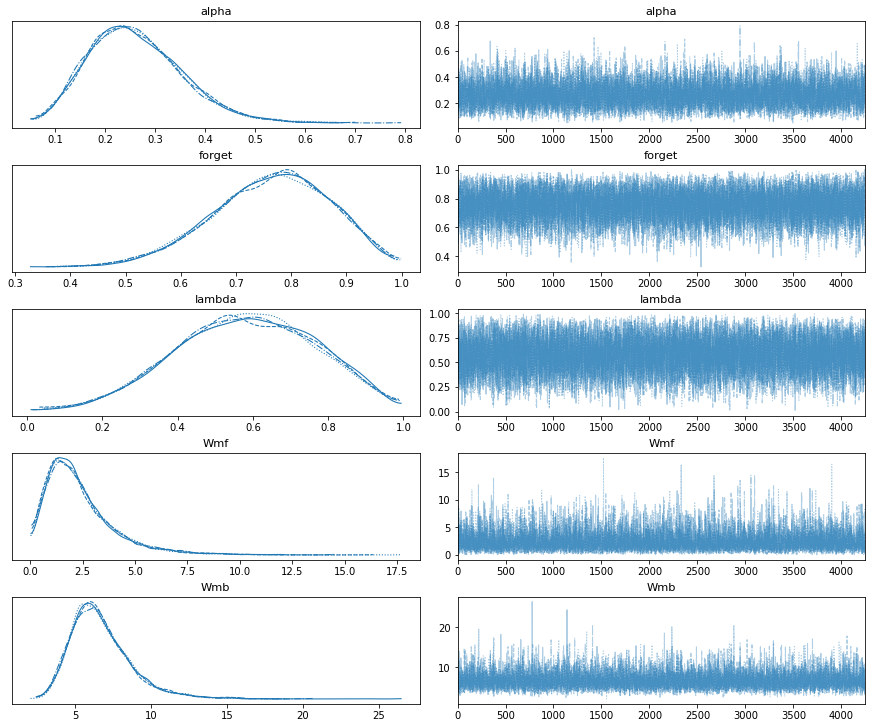

In [41]:
az.plot_trace(sm);

In [ ]:
print(fit_Hyb)

In [ ]:
az.plot_trace(fit_Hyb)